# Parametric EM (missing data)

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb


# the databases will be saved in "out/*.csv"
EMnomissing = "out/EM_nomissing.csv"
EMmissing = "out/EM_missing.csv"

## Generating data with missing values (at random)

In [2]:
src = gum.fastBN("A->B<-C->D->E<-B;D->F")
gum.generateSample(src, 5000, EMnomissing, random_order=False)
src

(pyagrum.BayesNet@0x55c74219dd50) BN{nodes: 6, arcs: 6, domainSize: 64, dim: 14, mem: 224o}

In [3]:
import pandas as pd
import numpy as np


def add_missing(src, dst, proba):
  df = pd.read_csv(src)
  mask = np.random.choice([True, False], size=df.shape, p=[proba, 1 - proba])
  df.mask(mask).to_csv(dst, na_rep="?", index=False, float_format="%.0f")


gum.generateSample(src, 5000, EMnomissing, random_order=False)
add_missing(EMnomissing, EMmissing, proba=0.1)

In [4]:
print("No missing")
with open(EMnomissing, "r") as srcfile:
  for _ in range(10):
    print(srcfile.readline(), end="")
print("Missing")
with open(EMmissing, "r") as srcfile:
  for _ in range(10):
    print(srcfile.readline(), end="")

No missing
A,B,C,D,E,F
0,1,0,1,1,1
1,1,0,1,1,1
1,1,1,1,0,1
1,0,0,1,1,1
0,1,0,1,0,1
1,1,0,0,0,1
0,1,1,0,0,1
0,0,0,0,0,1
1,1,0,1,1,1
Missing
A,B,C,D,E,F
0,1,0,1,1,1
1,?,0,1,1,1
1,1,1,?,0,1
1,0,0,1,1,1
0,1,0,1,0,1
1,1,0,0,0,1
0,1,1,0,0,1
0,0,0,0,?,1
1,1,0,1,1,1


## Basic learning with missing data

In [5]:
# we create here a BNLearner specifying:
#   1. the filename of the database
#   2. a Bayes net (src) that enables to easily specify the variables
#      of interest in this database as well as their features (domain, etc.)
#   3. a list of the strings representing the missing data in the database
learner = gum.BNLearner(EMmissing, src, ["?"])
print(f"Missing values in {EMmissing} : {learner.hasMissingValues()}")

Missing values in out/EM_missing.csv : True


In [6]:
# learning the parameters makes sense only for a given Bayes net structure.
# so, below, we pass in argument to Method learnParameter() the graphical
# structure of Bayes net src
try:
  learner.learnParameters(src.dag())
except gum.MissingValueInDatabase:
  print("Learning is not possible without EM if there are some missing values.")

# note that, by default, the BNLearner is not capable of estimating parameters
# from a database. This requires a way to inpute the missing values in order to
# avoid introducing biases.

Learning is not possible without EM if there are some missing values.


In [7]:
# here, we indicate to the BNLearner that we wish to use EM to inpute missing values
# using the Expectation/Maximization (EM) algorithm. Method useEM() sets the
# stopping criterion of the algorithm to the min log-likelihood evolution rate, i.e.,
# at each of its iterations, EM computes the log-likelihood of the inputed data.
# Let LLc and LLp be the log-likelihoods at the current and the previous iterations
# respectively. Then, useEM(1e-4) specifies that EM should stop when 
# (LLc - LLp) / LLc < 1e-4
learner.useEM(1e-4)

# at each iteration, EM estimates the parameters using a learning score and a prior.
# you can specify which ones you wish to use
learner.useSmoothingPrior()
print(learner)

# to be user-frendly, these methods can be chained:
learner.useEM(1e-3) \
       .useSmoothingPrior() \
       .useScoreAIC()

# perform the parameter learning using EM
bn = learner.learnParameters(src.dag())
gnb.flow.row(
  gnb.getInference(src),
  gnb.getInference(bn),
  captions=["Source", f"EM Estimation after {learner.nbrEMIterations()} iteration(s)"],
)

Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : Smoothing
Prior weight         : 1.000000
EM                   : True
EM stopping criteria : [MinRate: 0.0001, MaxIter: 10000]



In [8]:
# you can check for which reason EM stopped its iterations
print("EM 1", learner.EMState())

# here, in addition to the log-likelihood min rate, we limit the number of iterations
learner.setEMMaxIter(2)
bn = learner.learnParameters(src.dag())
print("EM 2", learner.EMState())

# remove the max iteration criterion
learner.disableEMMaxIter()

EM 1 stopped with rate=0.001
EM 2 stopped with max iteration=2


(pyagrum.BNLearner@0x55c742867580) Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : Smoothing
Prior weight         : 1.000000
EM                   : True
EM stopping criteria : [MinRate: 0.001]

## Learning with smaller error (and no smoothing)

In [9]:
learner = gum.BNLearner(EMmissing, src, ["?"])
learner.useEM(1e-8) \
       .setEMVerbosity(True)

bn2 = learner.learnParameters(src.dag())
gnb.flow.row(
  gnb.getInference(src),
  gnb.getInference(bn2),
  captions=["Source", f"EM Estimation after {learner.nbrEMIterations()} iteration(s)"],
)

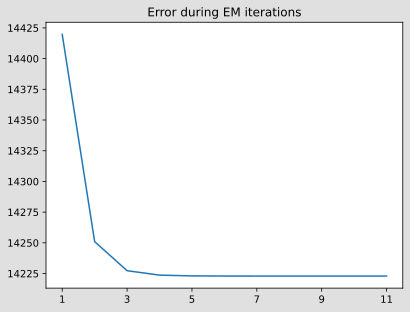

In [10]:
import matplotlib.pyplot as plt

# display -log-likelihood
plt.plot(np.arange(1, 1 + learner.nbrEMIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.nbrEMIterations(), step=2))
plt.title("Error during EM iterations");

## Setting EM's stopping criteria

There are 3 methods to enable EM:

<ol>
    <li><code>useEM()</code> that, implicitly, sets the log-likelihood evolution
        rate as the primary stopping criterion</li>
    <li><code>useEMWithRateCriterion()</code>, which is an alias for useEM()</li>
    <li><code>useEMWithDiffCriterion()</code>, which sets the difference between two consecutive
        log-likelihoods as the primary stopping criterion</li>
</ol>

learning with the min log-likelihood evolution rate criterion
stopped with rate=0.001
learning with the min log-likelihood difference criterion
stopped with epsilon=0.5


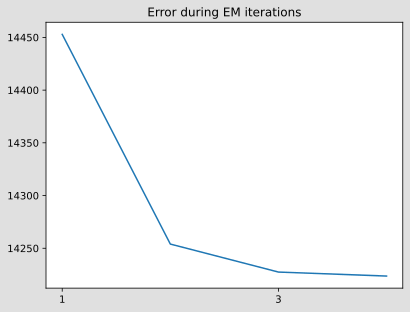

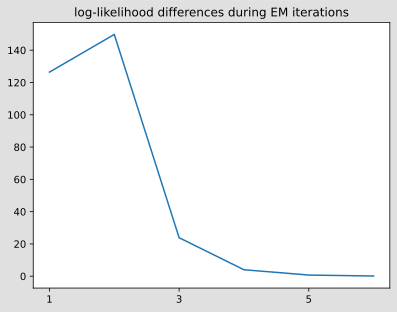

In [11]:
# here, we enable EM and enforce that it will stop when the log-likelihood 
# evolution rate drops below 1e-3
print("learning with the min log-likelihood evolution rate criterion")
learner.useEMWithRateCriterion(1e-3)
learner.learnParameters(src.dag())
print(learner.EMState())

plt.figure()
plt.plot(np.arange(1, 1 + learner.nbrEMIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.nbrEMIterations(), step=2))
plt.title("Error during EM iterations");

# setting EM to stop when the difference between two consecutive log-likelihood
# drops below 0.5
print("learning with the min log-likelihood difference criterion")
learner.useEMWithDiffCriterion(0.5)
learner.learnParameters(src.dag())
print(learner.EMState())

plt.figure()
plt.plot(np.arange(1, 1 + learner.nbrEMIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.nbrEMIterations(), step=2))
plt.title("log-likelihood differences during EM iterations");


It is possible to specify several stopping criteria. In this case, EM stops
when at least one of the criteria is not met.<br/>
Note that Min log-likelihood difference and Min-log-likelihood evolution rate
are mutually exclusive.

In [12]:
# the following learner will stop whenever the difference between two consecutive
# log-likelihoods drops below 0.5 OR whenever it has performed 4 iterations OR
# whenever it has already been executed for 200 milliseconds.
learner.useEMWithDiffCriterion(0.5) \
       .setEMMaxIter(4) \
       .setEMMaxTime(200)

print(learner)

Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : -
EM                   : True
EM stopping criteria : [MinDiff: 0.5MaxIter: 4MaxTime: 200]



In [13]:
# Of course, it is always possible to disable previously selected criteria
print(learner)

# remove the max iter criterion and the min diff criterion
learner.disableEMMaxIter() \
       .disableEMEpsilon()

print('================================')
print(learner)

Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : -
EM                   : True
EM stopping criteria : [MinDiff: 0.5MaxIter: 4MaxTime: 200]

Filename             : out/EM_missing.csv
Size                 : (5000,6)
Variables            : A[2], B[2], C[2], D[2], E[2], F[2]
Induced types        : False
Missing values       : True
Algorithm            : MIIC
Correction           : MDL
Prior                : -
EM                   : True
EM stopping criteria : [MaxTime: 200]



## Initializing the EM algorithm

EM's philosophy consists of inputing missing values using the Bayes net
learnt at the previous iteration. This means that it requires an initial
model. When using Method learnParameter(dag), this one has the graphical
structure corresponding to dag, and its parameters are learnt using an
estimator that does not take into account the missing values.

The conditional probability tables (CPT) of the initial Bayes net can be
perturbed, so that we can execute EM with multi-starts. In this
case, the CPTs are updated using the following formula:<br/>
new_CPT = (1-noise) * CPT + noise * random_CPT

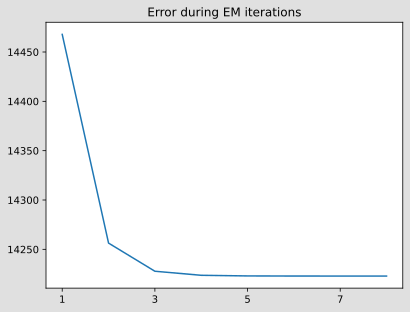

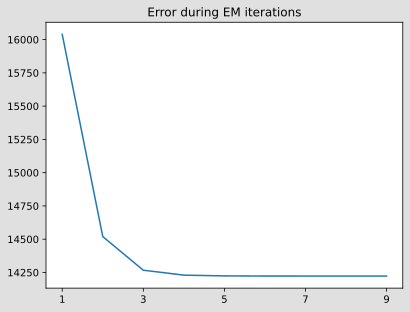

In [14]:
learner = gum.BNLearner(EMmissing, src, ["?"])
learner.useEM(1e-6).setEMVerbosity(True)

# use the pyagrum estimator to initialize EM's CPTs and a noise
# set by default to 0.1
learner.learnParameters(src.dag())

plt.figure()
plt.plot(np.arange(1, 1 + learner.nbrEMIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.nbrEMIterations(), step=2))
plt.title("Error during EM iterations");

# define another noise
learner.useEM(1e-6, 0.9) # noise = 0.9
learner.learnParameters(src.dag())

plt.figure()
plt.plot(np.arange(1, 1 + learner.nbrEMIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.nbrEMIterations(), step=2))
plt.title("Error during EM iterations");

In the above cell, before perturbing the CPTs of the EM's initial Bayes net,
those were estimated from the dataset. This prevents exploiting user knowledge.
to fix this issue, instead of passing a DAG as a parameter to Method
<code>learnParameters()</code>, it is possible to pass a Bayes net. In this
case, for the CPTs of this Bayes net that are fully filled with zeroes, EM's
initial CPTs are estimated as described above, but the other CPTs are considered 
as the initial values to be taken into account before the noise perturbations.

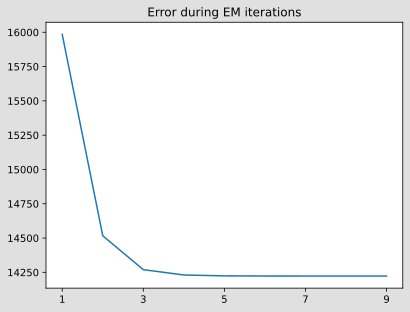

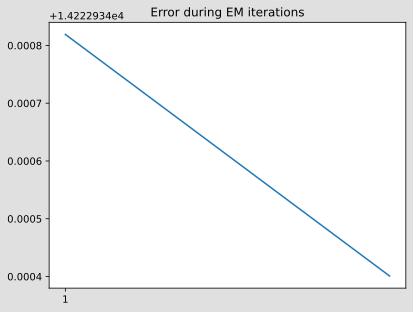

In [15]:
# first learning with EM
learner.useEM(1e-6, 0.9) 
bn = learner.learnParameters(src.dag())

plt.figure()
plt.plot(np.arange(1, 1 + learner.nbrEMIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.nbrEMIterations(), step=2))
plt.title("Error during EM iterations");

# relaunch EM but initializing the CPTs with those of BN
learner.useEM(1e-6, 0.0) # no noise
learner.learnParameters(bn)

plt.figure()
plt.plot(np.arange(1, 1 + learner.nbrEMIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.nbrEMIterations(), step=2))
plt.title("Error during EM iterations");

In [16]:
# of course, not all the CPTs need be initialized by the user
bn.cpt('A').fillWith([0.0] * 2)
bn.cpt('B').fillWith([0.0] * 8)
bn.cpt('D').fillWith([0.0] * 4)
bn.cpt('F').fillWith([0.0] * 4)
gnb.show(bn.cpt('A'))
gnb.show(bn.cpt('B'))
gnb.show(bn.cpt('C'))
gnb.show(bn.cpt('D'))
gnb.show(bn.cpt('E'))
gnb.show(bn.cpt('F'))

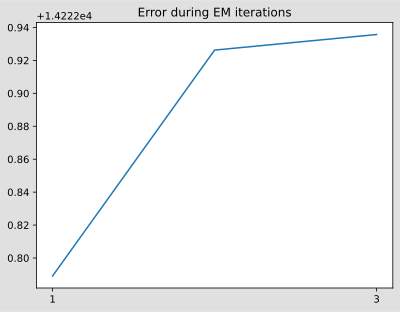

In [18]:
# the CPTs of C and E are initialized as shown in the preceding cell, the
# other ones are estimated from the database. Then all the CPTs are
# perturbed and EM starts its expectation/maximization iterations
bn = learner.learnParameters(bn)

plt.figure()
plt.plot(np.arange(1, 1 + learner.nbrEMIterations()), learner.EMHistory())
plt.xticks(np.arange(1, 1 + learner.nbrEMIterations(), step=2))
plt.title("Error during EM iterations");